In [139]:
from importlib.metadata import version
import nltk
import tensorflow
import summa
import numpy as np
import pandas as pd
nltk.download('stopwords')
print(nltk.__version__)
print(tensorflow.__version__)
print(pd.__version__)
print(version('summa'))

3.6.5
2.6.0
1.3.3
1.2.0


[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [140]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')
data.sample(3)

,headlines,text
283,Rajkummar Rao to replace SRK in Rakesh Sharma ...,Actor Rajkummar Rao will replace Shah Rukh Kha...
89498,Sharapova's wildcards driven by media coverage...,World number one Andy Murray has claimed that ...
72895,FreshWorks buys Chennai-based Zarget in 9th ac...,"Customer engagement platform Freshworks, forme..."


텍스트 전처리

In [142]:
# Step 2. 데이터 전처리하기 (추상적 요약)   
# 실습에서 사용된 전처리를 참고하여 각자 필요하다고 생각하는 전처리를 추가 사용하여 텍스트를 정규화 또는 정제해 보세요. 
# 만약, 불용어 제거를 선택한다면 상대적으로 길이가 짧은 요약 데이터에 대해서도 불용어를 제거하는 것이 좋을지 고민해 보세요. 
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

In [143]:
print('Total len:', (len(data)))

Total len: 98401


In [144]:
#  중복 샘플이므로 제거 필요
print(data['text'].nunique(),  data['headlines'].nunique())

98360 98280


In [145]:
data.drop_duplicates(subset = ['text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


In [146]:
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


In [147]:
#텍스트 정규화와 불용어 제거
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


In [148]:
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
#     sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub(r'[^\w\s]', ' ', sentence)
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (headline)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [150]:
# temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
# temp_headlines = 'Great way to start (or finish) the day!!!'

# print("text: ", preprocess_sentence(temp_text))
# print("headlines:", preprocess_sentence(temp_headlines, False)) 

text:  everything bought great infact ordered twice third ordered wasfor mother father
headlines: great way to start the day


In [128]:
# wasfor 에 대한 처리 추가 필요

In [151]:
clean_text = []
clean_head = []

for text in data['text']:
    text = preprocess_sentence(text,False)
    clean_text.append(text)
for head in data['headlines']:
    head = preprocess_sentence(head,False)
    clean_head.append(head)

In [152]:
print("text preprocess: ", clean_text[:5])
print("headlines preprocess: ", clean_head[:5])

text preprocess:  ['saurav kant an alumnus of upgrad and iiit pg program in machine learning and artificial intelligence was sr systems engineer at infosys with almost years of work experience the program and upgrad 360 degree career support helped him transition to data scientist at tech mahindra with 90 salary hike upgrad online power learning has powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance to win free food from swiggy for one year pranav kaushik delhi techie bagged this reward after spending 2000 cred coins users get one cred coin per rupee of bill paid which can be used to avail rewards from brands like ixigo bookmyshow ubereats cult fit and more', 'new zealand defeated india by wickets in the fourth odi at hamilton on thursday to win their first match of the five match odi series india lost an international match under rohit sharma captaincy after 12 consecutive victories dating back to march 2018 the match witnessed india getting al

In [153]:
# empty 샘플이 생겼는지 확인
data['text'] = clean_text
data['headlines'] = clean_head

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)
data.isnull().sum()

headlines    0
text         0
dtype: int64

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 74
텍스트의 평균 길이 : 57.51595160634404
요약의 최소 길이 : 1
요약의 최대 길이 : 16
요약의 평균 길이 : 9.592303782025214


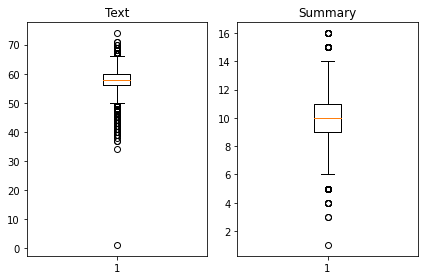

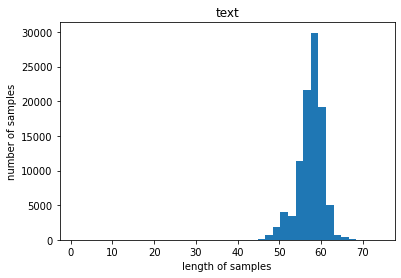

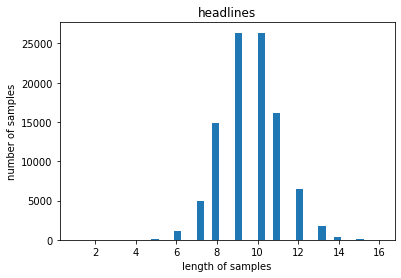

In [154]:
# 훈련데이터와 테스트데이터 나누기
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
summary_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(summary_len)))
print('요약의 최대 길이 : {}'.format(np.max(summary_len)))
print('요약의 평균 길이 : {}'.format(np.mean(summary_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('Text')
plt.subplot(1,2,2)
plt.boxplot(summary_len)
plt.title('Summary')
plt.tight_layout()
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('headlines')
plt.hist(summary_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [155]:
# TODO: 통계적 분석 필요
text_max_len = 68 #50
headlines_max_len = 12

In [156]:
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['headlines'].apply(lambda x: len(x.split()) <= headlines_max_len)]

In [157]:
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 96166


시작 토큰과 종료 토큰 추가

In [158]:
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostk '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostk')
data.head(3)

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches to career in ml al wit...,saurav kant an alumnus of upgrad and iiit pg p...,sostk upgrad learner switches to career in ml ...,upgrad learner switches to career in ml al wit...
1,delhi techie wins free food from swiggy for on...,kunal shah credit card bill payment platform c...,sostk delhi techie wins free food from swiggy ...,delhi techie wins free food from swiggy for on...
2,new zealand end rohit sharma led india 12 matc...,new zealand defeated india by wickets in the f...,sostk new zealand end rohit sharma led india 1...,new zealand end rohit sharma led india 12 matc...


In [159]:
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

In [160]:
# 데이터셋 분리
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]
n_of_val = int(len(encoder_input)*0.2) #0.2%
print('테스트 데이터의 수 :', n_of_val)

[21182 21786 30831 ... 44257 31628 67212]
테스트 데이터의 수 : 19233


In [161]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 76933
훈련 레이블의 개수 : 76933
테스트 데이터의 개수 : 19233
테스트 레이블의 개수 : 19233


In [162]:
# 정수 인코딩
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

In [163]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 73540
등장 빈도가 6번 이하인 희귀 단어의 수: 50395
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 23145
단어 집합에서 희귀 단어의 비율: 68.52733206418276
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 2.299432750512202


In [116]:
# 등장 빈도가 6회 이하인 단어들은 정수 인코딩 과정에서 빼고, 훈련 데이터에서 제거하고자 합니다. 
# 위에서 이를 제외한 단어 집합의 크기를 8천여 개로 계산했는데, 이와 비슷한 값으로 어림잡아 단어 집합의 크기를 8,000으로 제한해볼게요. 
# 토크나이저를 정의할 때 num_words의 값을 정해주면, 단어 집합의 크기를 제한할 수 있어요.

In [164]:
src_vocab = 22900#8000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성

In [165]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)
print(encoder_input_train[:3])

[[110, 1059, 253, 7, 9, 10, 16, 306, 20229, 12, 735, 1307, 2, 1421, 609, 44, 204, 10, 464, 13, 12, 3639, 114, 3, 16, 4170, 1059, 62, 9, 10, 20229, 8429, 2, 900, 62, 4170, 3, 709, 5, 7, 313, 1285, 1, 294, 3, 709, 10, 13, 1069, 2, 1793], [2408, 3, 79, 11, 5817, 4, 6849, 127, 22, 8324, 6, 7757, 3, 536, 79, 6, 137, 1, 235, 1679, 70, 524, 30, 54, 2712, 11, 805, 2, 1261, 19, 16, 222, 83, 290, 6, 3808, 1203, 58, 5, 44, 59, 325, 16, 11677, 15, 2237, 2926, 321, 410, 2, 1, 9986, 2, 4869, 1, 291], [1725, 340, 946, 4364, 337, 7, 163, 10, 1, 86, 21, 2029, 38, 1070, 75, 61, 3, 203, 6421, 8, 610, 5, 1560, 400, 1, 86, 7, 40, 1387, 2093, 8, 9328, 291, 19, 59, 185, 667, 2, 236, 8, 857, 242, 36, 400, 170, 2093, 21, 24, 1141, 8, 291, 488, 19, 1725, 3459, 2, 1, 185, 667]]


In [166]:
#decoder
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [167]:
threshold = 7
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 32585
등장 빈도가 6번 이하인 희귀 단어의 수: 22787
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 9798
단어 집합에서 희귀 단어의 비율: 69.93094982353844
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.815488095547318


In [168]:
tar_vocab = 9700 #2000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 4106, 4, 6640, 432, 7, 138, 2617, 720], [1, 2525, 3165, 6, 4666, 66, 12, 5810, 7, 26, 4667], [1, 24, 994, 618, 50, 32, 4, 980, 4, 165, 846, 246], [1, 7928, 2096, 1104, 7, 2074, 1516, 5341, 4, 2668, 1974], [1, 794, 4817, 1788, 19, 1517, 72, 7, 1913, 93, 1037]]
target
decoder  [[4106, 4, 6640, 432, 7, 138, 2617, 720, 2], [2525, 3165, 6, 4666, 66, 12, 5810, 7, 26, 4667, 2], [24, 994, 618, 50, 32, 4, 980, 4, 165, 846, 246, 2], [7928, 2096, 1104, 7, 2074, 1516, 5341, 4, 2668, 1974, 2], [794, 4817, 1788, 19, 1517, 72, 7, 1913, 93, 1037, 2]]


패딩

In [187]:
#padding
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=headlines_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=headlines_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=headlines_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=headlines_max_len, padding='post')

## Model    
Step 3. 어텐션 메커니즘 사용하기 (추상적 요약)      
일반적인 seq2seq보다는 어텐션 메커니즘을 사용한 seq2seq를 사용하는 것이 더 나은 성능을 얻을 수 있어요.   
실습 내용을 참고하여 어텐션 메커니즘을 사용한 seq2seq를 설계해 보세요.   

In [171]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.layers import AdditiveAttention
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

In [172]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, vocab_size, vocab_dim, hidden_size, dropout=0.4):
        super().__init__()
        self.embed = Embedding(vocab_size, vocab_dim)
        self.lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=dropout)
        self.lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=dropout)
        self.lstm3 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=dropout)

    def call(self, inputs, training=False):
        embed = self.embed(inputs)
        out1, state_h1, state_c1 = self.lstm1(embed, training=training)
        out2, state_h2, state_c2 = self.lstm2(out1, training=training)
        out3, state_h3, state_c3 = self.lstm3(out2, training=training)

        return out3, state_h3, state_c3


class Decoder(tf.keras.layers.Layer):
    def __init__(self, vocab_size, embed_dim, hidden_size, dropout=0.4):
        super().__init__()
        self.embedding = Embedding(vocab_size, embed_dim)
        self.lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=dropout)
        self.attention = AdditiveAttention()
        self.dense = Dense(vocab_size, activation='softmax')

    def call(self, inputs, enc_output, initial_state, training=False):
        embedded = self.embedding(inputs)
        lstm_out, h, c = self.lstm(embedded, initial_state=initial_state, training=training)
        attn_output = self.attention([lstm_out, enc_output], training=training) # Pass encoder output
        decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([lstm_out, attn_output])
        outputs = self.dense(decoder_concat_input)
        return outputs, h, c

## Optuna

In [38]:
!pip install optuna

     |████████████████████████████████| 383 kB 4.8 MB/s            
     |████████████████████████████████| 3.1 MB 56.1 MB/s            
     |████████████████████████████████| 233 kB 73.1 MB/s            
     |████████████████████████████████| 78 kB 12.1 MB/s            
     |████████████████████████████████| 597 kB 71.9 MB/s            
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 4.0.1
    Uninstalling typing-extensions-4.0.1:
      Successfully uninstalled typing-extensions-4.0.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-gpu 2.6.0 requires numpy~=1.19.2, but you have numpy 1.21.4 which is incompatible.
tensorflow-gpu 2.6.0 requires six~=1.15.0, but you have six 1.16.0 which is incompatible.
tensorflow-gpu 2.6.0 requires typing-extensions~=3.7.4, but you have typing-extensions 4.12.2 which is

In [41]:
import optuna
# import tensorflow as tf
# from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, AdditiveAttention
# from tensorflow.keras.models import Model
# from tensorflow.keras.callbacks import EarlyStopping

In [42]:
def create_model(trial):
    embed_dim = trial.suggest_int('embed_dim', 64, 128)
    hidden_size = trial.suggest_int('hidden_size', 128, 256)

    # Encoder
    enc_inputs = Input(shape=(text_max_len,))
    encoder = Encoder(src_vocab, embed_dim, hidden_size, dropout=0.4)

    enc_output, state_h, state_c = encoder(enc_inputs)

    # Decoder
    dec_inputs = Input(shape=(None,))
    decoder = Decoder(tar_vocab, embed_dim, hidden_size, dropout=0.4)

    dec_outputs, _, _ = decoder(dec_inputs, enc_output, initial_state=[state_h, state_c])

    model = Model([enc_inputs, dec_inputs], dec_outputs)

    optimizer = trial.suggest_categorical('optimizer', ['rmsprop', 'adam'])
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy')

    return model


def objective(trial):
    model = create_model(trial)
    es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)

    history = model.fit(
        x=[encoder_input_train, decoder_input_train],
        y=decoder_target_train,
        validation_data=([encoder_input_test, decoder_input_test], decoder_target_test),
        batch_size=256,
        callbacks=[es],
        epochs=50,
        verbose=1  
    )

    # Get best validation loss 
    best_val_loss = min(history.history['val_loss'])
    return best_val_loss


study = optuna.create_study(direction='minimize')  
study.optimize(objective, n_trials=10)  

[I 2025-02-07 07:17:23,948] A new study created in memory with name: no-name-483e4220-b8c5-4ad0-ac8e-02b0962e9ce6


Epoch 1/50
291/291 [==============================] - 20s 44ms/step - loss: 4.2405 - val_loss: 3.9608
Epoch 2/50
291/291 [==============================] - 12s 40ms/step - loss: 3.8234 - val_loss: 3.6469
Epoch 3/50
291/291 [==============================] - 12s 41ms/step - loss: 3.5753 - val_loss: 3.4934
Epoch 4/50
291/291 [==============================] - 12s 42ms/step - loss: 3.4277 - val_loss: 3.3607
Epoch 5/50
291/291 [==============================] - 12s 42ms/step - loss: 3.2937 - val_loss: 3.2476
Epoch 6/50
291/291 [==============================] - 12s 43ms/step - loss: 3.1807 - val_loss: 3.1544
Epoch 7/50
291/291 [==============================] - 13s 43ms/step - loss: 3.0863 - val_loss: 3.0779
Epoch 8/50
291/291 [==============================] - 12s 43ms/step - loss: 3.0069 - val_loss: 3.0232
Epoch 9/50
291/291 [==============================] - 12s 42ms/step - loss: 2.9388 - val_loss: 2.9741
Epoch 10/50
291/291 [==============================] - 12s 42ms/step - loss: 2.879

[I 2025-02-07 07:26:34,847] Trial 0 finished with value: 2.587514877319336 and parameters: {'embed_dim': 71, 'hidden_size': 147, 'optimizer': 'rmsprop'}. Best is trial 0 with value: 2.587514877319336.


Epoch 00044: early stopping
Epoch 1/50
291/291 [==============================] - 20s 52ms/step - loss: 4.2175 - val_loss: 3.9166
Epoch 2/50
291/291 [==============================] - 14s 49ms/step - loss: 3.7994 - val_loss: 3.6250
Epoch 3/50
291/291 [==============================] - 14s 49ms/step - loss: 3.5524 - val_loss: 3.4595
Epoch 4/50
291/291 [==============================] - 14s 49ms/step - loss: 3.3830 - val_loss: 3.3144
Epoch 5/50
291/291 [==============================] - 14s 49ms/step - loss: 3.2394 - val_loss: 3.2010
Epoch 6/50
291/291 [==============================] - 14s 49ms/step - loss: 3.1248 - val_loss: 3.1127
Epoch 7/50
291/291 [==============================] - 14s 49ms/step - loss: 3.0325 - val_loss: 3.0410
Epoch 8/50
291/291 [==============================] - 14s 50ms/step - loss: 2.9540 - val_loss: 2.9799
Epoch 9/50
291/291 [==============================] - 14s 50ms/step - loss: 2.8869 - val_loss: 2.9301
Epoch 10/50
291/291 [==============================] -

[I 2025-02-07 07:37:23,176] Trial 1 finished with value: 2.57277250289917 and parameters: {'embed_dim': 72, 'hidden_size': 165, 'optimizer': 'rmsprop'}. Best is trial 1 with value: 2.57277250289917.


Epoch 00045: early stopping
Epoch 1/50
291/291 [==============================] - 22s 59ms/step - loss: 4.2090 - val_loss: 3.9179
Epoch 2/50
291/291 [==============================] - 16s 56ms/step - loss: 3.7751 - val_loss: 3.5944
Epoch 3/50
291/291 [==============================] - 16s 56ms/step - loss: 3.5136 - val_loss: 3.4205
Epoch 4/50
291/291 [==============================] - 16s 56ms/step - loss: 3.3362 - val_loss: 3.2653
Epoch 5/50
291/291 [==============================] - 16s 56ms/step - loss: 3.1948 - val_loss: 3.1591
Epoch 6/50
291/291 [==============================] - 16s 56ms/step - loss: 3.0797 - val_loss: 3.0613
Epoch 7/50
291/291 [==============================] - 16s 56ms/step - loss: 2.9824 - val_loss: 3.0035
Epoch 8/50
291/291 [==============================] - 16s 56ms/step - loss: 2.8997 - val_loss: 2.9337
Epoch 9/50
291/291 [==============================] - 16s 56ms/step - loss: 2.8287 - val_loss: 2.8842
Epoch 10/50
291/291 [==============================] -

[I 2025-02-07 07:47:17,501] Trial 2 finished with value: 2.5804829597473145 and parameters: {'embed_dim': 77, 'hidden_size': 188, 'optimizer': 'rmsprop'}. Best is trial 1 with value: 2.57277250289917.


Epoch 00036: early stopping
Epoch 1/50
291/291 [==============================] - 18s 47ms/step - loss: 4.2368 - val_loss: 3.9513
Epoch 2/50
291/291 [==============================] - 13s 43ms/step - loss: 3.8262 - val_loss: 3.6637
Epoch 3/50
291/291 [==============================] - 13s 43ms/step - loss: 3.5746 - val_loss: 3.4767
Epoch 4/50
291/291 [==============================] - 12s 43ms/step - loss: 3.3999 - val_loss: 3.3300
Epoch 5/50
291/291 [==============================] - 12s 42ms/step - loss: 3.2624 - val_loss: 3.2243
Epoch 6/50
291/291 [==============================] - 12s 42ms/step - loss: 3.1539 - val_loss: 3.1346
Epoch 7/50
291/291 [==============================] - 12s 42ms/step - loss: 3.0661 - val_loss: 3.0697
Epoch 8/50
291/291 [==============================] - 12s 42ms/step - loss: 2.9894 - val_loss: 3.0161
Epoch 9/50
291/291 [==============================] - 12s 43ms/step - loss: 2.9204 - val_loss: 2.9554
Epoch 10/50
291/291 [==============================] -

[I 2025-02-07 07:57:14,323] Trial 3 finished with value: 2.5650789737701416 and parameters: {'embed_dim': 81, 'hidden_size': 145, 'optimizer': 'rmsprop'}. Best is trial 3 with value: 2.5650789737701416.


Epoch 00045: early stopping
Epoch 1/50
291/291 [==============================] - 27s 76ms/step - loss: 4.1710 - val_loss: 3.8492
Epoch 2/50
291/291 [==============================] - 21s 73ms/step - loss: 3.6907 - val_loss: 3.5456
Epoch 3/50
291/291 [==============================] - 21s 72ms/step - loss: 3.4281 - val_loss: 3.3246
Epoch 4/50
291/291 [==============================] - 21s 72ms/step - loss: 3.2337 - val_loss: 3.1775
Epoch 5/50
291/291 [==============================] - 21s 72ms/step - loss: 3.0814 - val_loss: 3.0613
Epoch 6/50
291/291 [==============================] - 21s 73ms/step - loss: 2.9610 - val_loss: 2.9742
Epoch 7/50
291/291 [==============================] - 21s 72ms/step - loss: 2.8611 - val_loss: 2.9047
Epoch 8/50
291/291 [==============================] - 21s 72ms/step - loss: 2.7753 - val_loss: 2.8462
Epoch 9/50
291/291 [==============================] - 21s 72ms/step - loss: 2.6990 - val_loss: 2.7961
Epoch 10/50
291/291 [==============================] -

[I 2025-02-07 08:07:13,899] Trial 4 finished with value: 2.569812297821045 and parameters: {'embed_dim': 103, 'hidden_size': 234, 'optimizer': 'rmsprop'}. Best is trial 3 with value: 2.5650789737701416.


Epoch 00028: early stopping
Epoch 1/50
291/291 [==============================] - 25s 67ms/step - loss: 4.1800 - val_loss: 3.8674
Epoch 2/50
291/291 [==============================] - 19s 65ms/step - loss: 3.7075 - val_loss: 3.5228
Epoch 3/50
291/291 [==============================] - 19s 64ms/step - loss: 3.4368 - val_loss: 3.3499
Epoch 4/50
291/291 [==============================] - 18s 63ms/step - loss: 3.2552 - val_loss: 3.1908
Epoch 5/50
291/291 [==============================] - 18s 63ms/step - loss: 3.1095 - val_loss: 3.0841
Epoch 6/50
291/291 [==============================] - 19s 64ms/step - loss: 2.9933 - val_loss: 3.0008
Epoch 7/50
291/291 [==============================] - 18s 64ms/step - loss: 2.8983 - val_loss: 2.9339
Epoch 8/50
291/291 [==============================] - 18s 64ms/step - loss: 2.8168 - val_loss: 2.8730
Epoch 9/50
291/291 [==============================] - 18s 63ms/step - loss: 2.7451 - val_loss: 2.8281
Epoch 10/50
291/291 [==============================] -

[I 2025-02-07 08:18:03,116] Trial 5 finished with value: 2.5569112300872803 and parameters: {'embed_dim': 120, 'hidden_size': 197, 'optimizer': 'rmsprop'}. Best is trial 5 with value: 2.5569112300872803.


Epoch 00033: early stopping
Epoch 1/50
291/291 [==============================] - 26s 73ms/step - loss: 4.2904 - val_loss: 4.0192
Epoch 2/50
291/291 [==============================] - 21s 71ms/step - loss: 3.9742 - val_loss: 3.8732
Epoch 3/50
291/291 [==============================] - 20s 70ms/step - loss: 3.7854 - val_loss: 3.6674
Epoch 4/50
291/291 [==============================] - 20s 69ms/step - loss: 3.5958 - val_loss: 3.4799
Epoch 5/50
291/291 [==============================] - 20s 70ms/step - loss: 3.4161 - val_loss: 3.3207
Epoch 6/50
291/291 [==============================] - 20s 70ms/step - loss: 3.2397 - val_loss: 3.1750
Epoch 7/50
291/291 [==============================] - 20s 70ms/step - loss: 3.0827 - val_loss: 3.0441
Epoch 8/50
291/291 [==============================] - 20s 70ms/step - loss: 2.9472 - val_loss: 2.9381
Epoch 9/50
291/291 [==============================] - 20s 70ms/step - loss: 2.8300 - val_loss: 2.8611
Epoch 10/50
291/291 [==============================] -

[I 2025-02-07 08:28:10,847] Trial 6 finished with value: 2.5317976474761963 and parameters: {'embed_dim': 121, 'hidden_size': 232, 'optimizer': 'adam'}. Best is trial 6 with value: 2.5317976474761963.


Epoch 00029: early stopping
Epoch 1/50
291/291 [==============================] - 26s 70ms/step - loss: 4.3094 - val_loss: 4.0413
Epoch 2/50
291/291 [==============================] - 20s 68ms/step - loss: 3.9837 - val_loss: 3.8564
Epoch 3/50
291/291 [==============================] - 20s 67ms/step - loss: 3.7666 - val_loss: 3.6409
Epoch 4/50
291/291 [==============================] - 20s 67ms/step - loss: 3.5435 - val_loss: 3.3932
Epoch 5/50
291/291 [==============================] - 20s 67ms/step - loss: 3.2928 - val_loss: 3.1898
Epoch 6/50
291/291 [==============================] - 20s 67ms/step - loss: 3.1033 - val_loss: 3.0395
Epoch 7/50
291/291 [==============================] - 20s 68ms/step - loss: 2.9534 - val_loss: 2.9326
Epoch 8/50
291/291 [==============================] - 20s 67ms/step - loss: 2.8351 - val_loss: 2.8526
Epoch 9/50
291/291 [==============================] - 20s 67ms/step - loss: 2.7386 - val_loss: 2.7854
Epoch 10/50
291/291 [==============================] -

[I 2025-02-07 08:37:45,406] Trial 7 finished with value: 2.504713535308838 and parameters: {'embed_dim': 107, 'hidden_size': 215, 'optimizer': 'adam'}. Best is trial 7 with value: 2.504713535308838.


Epoch 00029: early stopping
Epoch 1/50
291/291 [==============================] - 29s 81ms/step - loss: 4.1861 - val_loss: 3.9094
Epoch 2/50
291/291 [==============================] - 23s 78ms/step - loss: 3.7416 - val_loss: 3.5540
Epoch 3/50
291/291 [==============================] - 22s 77ms/step - loss: 3.4467 - val_loss: 3.3439
Epoch 4/50
291/291 [==============================] - 22s 77ms/step - loss: 3.2408 - val_loss: 3.1803
Epoch 5/50
291/291 [==============================] - 23s 77ms/step - loss: 3.0905 - val_loss: 3.0660
Epoch 6/50
291/291 [==============================] - 23s 78ms/step - loss: 2.9679 - val_loss: 2.9822
Epoch 7/50
291/291 [==============================] - 23s 77ms/step - loss: 2.8662 - val_loss: 2.9015
Epoch 8/50
291/291 [==============================] - 22s 77ms/step - loss: 2.7793 - val_loss: 2.8438
Epoch 9/50
291/291 [==============================] - 22s 77ms/step - loss: 2.7025 - val_loss: 2.8005
Epoch 10/50
291/291 [==============================] -

[I 2025-02-07 08:48:00,687] Trial 8 finished with value: 2.590369939804077 and parameters: {'embed_dim': 86, 'hidden_size': 255, 'optimizer': 'rmsprop'}. Best is trial 7 with value: 2.504713535308838.


Epoch 00027: early stopping
Epoch 1/50
291/291 [==============================] - 19s 49ms/step - loss: 4.3643 - val_loss: 4.0682
Epoch 2/50
291/291 [==============================] - 13s 45ms/step - loss: 3.9998 - val_loss: 3.8597
Epoch 3/50
291/291 [==============================] - 13s 46ms/step - loss: 3.7421 - val_loss: 3.5610
Epoch 4/50
291/291 [==============================] - 13s 45ms/step - loss: 3.4633 - val_loss: 3.3472
Epoch 5/50
291/291 [==============================] - 13s 45ms/step - loss: 3.2694 - val_loss: 3.1987
Epoch 6/50
291/291 [==============================] - 13s 45ms/step - loss: 3.1349 - val_loss: 3.0912
Epoch 7/50
291/291 [==============================] - 13s 45ms/step - loss: 3.0246 - val_loss: 3.0041
Epoch 8/50
291/291 [==============================] - 13s 45ms/step - loss: 2.9325 - val_loss: 2.9388
Epoch 9/50
291/291 [==============================] - 13s 45ms/step - loss: 2.8532 - val_loss: 2.8842
Epoch 10/50
291/291 [==============================] -

[I 2025-02-07 08:57:20,897] Trial 9 finished with value: 2.50839900970459 and parameters: {'embed_dim': 76, 'hidden_size': 157, 'optimizer': 'adam'}. Best is trial 7 with value: 2.504713535308838.


Epoch 00042: early stopping


In [43]:
# number of trials를 충분히 설정후 학습후 확인 가능(시간제약 이슈로 생략)
trial = study.best_trial
print(f'  Params: {trial.params}')  

  Params: {'embed_dim': 107, 'hidden_size': 215, 'optimizer': 'adam'}


### Train with Best Hyper Params

In [173]:
embed_dim = 107
hidden_size = 215
encoder = Encoder(src_vocab, embed_dim, hidden_size)
decoder = Decoder(tar_vocab, embed_dim, hidden_size)


enc_inputs = Input(shape=(text_max_len,))
dec_inputs = Input(shape=(None,))

enc_output, state_h, state_c = encoder(enc_inputs)
dec_outputs, _, _ = decoder(dec_inputs, enc_output, initial_state=[state_h, state_c])

model = Model([enc_inputs, dec_inputs], dec_outputs)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
301/301 [==============================] - 40s 116ms/step - loss: 5.9142 - val_loss: 5.5187
Epoch 2/50
301/301 [==============================] - 35s 116ms/step - loss: 5.4646 - val_loss: 5.2783
Epoch 3/50
301/301 [==============================] - 36s 118ms/step - loss: 5.1366 - val_loss: 4.9130
Epoch 4/50
301/301 [==============================] - 35s 117ms/step - loss: 4.7432 - val_loss: 4.5844
Epoch 5/50
301/301 [==============================] - 36s 118ms/step - loss: 4.4203 - val_loss: 4.3647
Epoch 6/50
301/301 [==============================] - 36s 118ms/step - loss: 4.1608 - val_loss: 4.1768
Epoch 7/50
301/301 [==============================] - 36s 118ms/step - loss: 3.9440 - val_loss: 4.0507
Epoch 8/50
301/301 [==============================] - 36s 118ms/step - loss: 3.7599 - val_loss: 3.9575
Epoch 9/50
301/301 [==============================] - 36s 118ms/step - loss: 3.6034 - val_loss: 3.8870
Epoch 10/50
301/301 [==============================] - 36s 118ms/step - l

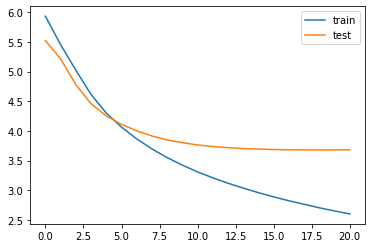

In [83]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

### Inference

In [174]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [175]:
# 인코더 설계
encoder_model = Model(inputs=enc_inputs, outputs=[enc_output, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb_layer = Embedding(tar_vocab, embed_dim)
dec_emb2 = dec_emb_layer(dec_inputs)

decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용.
# 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

attn_layer = AdditiveAttention(name='attention_layer')
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')

# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [dec_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [176]:
def decode_sequence(input_seq):
    
    text_max_len = 50
    summary_max_len = 8
    
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostk']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostk'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostk'  or len(decoded_sentence.split()) >= (summary_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

In [177]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2head(input_seq):
    target_word_index = tar_tokenizer.word_index
    target_index_to_word = tar_tokenizer.index_word
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=target_word_index['sostk']) and i!=target_word_index['eostk']):
            temp = temp + target_index_to_word[i]+' '
    return temp

In [178]:
target_word_index = tar_tokenizer.word_index
target_word_index['sostk']

1

Case1) stopwords True

In [90]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2head(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")


원문 : speaking experience working rajinikanth film kaala actress huma qureshi said simple human take stardom seriously disciplined meet question intimidated added huma said cannot begin learnt 
실제 요약 : rajinikanth is simple he does not take stardom seriously huma 
예측 요약 :  cooperation cooperation cooperation digital digital iraq iraq


원문 : cricket australia said look verbal spat took place australian vice captain david warner south african wicketkeeper quinton de kock first test sunday cctv footage shows exchange duo players climbed dressing rooms tea break day 
실제 요약 : warner de kock in exchange during tea break 
예측 요약 :  maradona maradona maradona maradona maradona jackman jackman


원문 : pm narendra modi friday tweeted enquired health dmk president karunanidhi daughter kanimozhi son mk stalin adding praying quick recovery offered assistance required family comes kauvery hospital said 94 year old leader health condition slightly declined 
실제 요약 : pm modi for karunanidhi health offers 

Case2) stopwords False

In [179]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2head(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")


원문 : us federal judge on tuesday blocked president donald trump executive order that sought to withhold federal funds from sanctuary cities saying the president has no authority to attach new conditions to federal spending the administration was taking action to appeal the ruling and will win at the supreme court level at some point white house officials said 
실제 요약 : judge blocks trump order to restrict sanctuary city funds 
예측 요약 :  cola cola cola cola cola cola cola


원문 : former rbi governor raghuram rajan has blamed over optimistic bankers growth slowdown and slow decision making by governments for bad loan crisis he added that larger number of bad loans originated between 2006 and 2008 when economic growth was strong it is at such times that banks make mistakes they past growth and performance to the future rajan further said 
실제 요약 : over responsible for bad loans rajan 
예측 요약 :  tapes tapes tapes tapes tapes exposed exposed


원문 : the hong kong electoral office has reported the

[이슈]    
수정한 코드에 문제가 있는지 요약이 제대로 진행되지 않고 단어를 반복하는 결과를 보였다.   
학습데이터에 stopwords 진행/비진행 비교를 해보고자하였으나, 위와 같은 이슈로 파악이 어렵다.   
원인은 아래 진행한 < Summa을 이용해서 추출적 요약해보기 > 이슈와 같은 원인으로 사료된다.

### Summa을 이용해서 추출적 요약해보기    

In [180]:
import requests
from summa.summarizer import summarize

In [181]:
text = requests.get('http://rare-technologies.com/the_matrix_synopsis.txt').text

In [182]:
print('Summary:')
print(summarize(text, ratio=0.005))

Summary:
Morpheus, Trinity, Neo, Apoc, Switch, Mouse and Cypher are jacked into the Matrix.
Trinity brings the helicopter down to the floor that Morpheus is on and Neo opens fire on the three Agents.


In [183]:
data['text'][5]

'pakistani singer rahat fateh ali khan has denied receiving any notice from the enforcement directorate over allegedly smuggling foreign currency out of india it would have been better if the authorities would have served the notice first if any and then publicised this reads press release issued on behalf of rahat the statement further called the allegation bizarre'

In [192]:
data['text'][5]
print('Summary:')
print(summarize(data['text'][5], ratio=0.5))

Summary:



[이슈]  
summarize가 data['text']에 대한 요약본이 출력되지 않는다. http://rare-technologies.com/the_matrix_synopsis.txt 데이터에 비해 길익가 짧은 data['text']가 원인이라고 생각하고 ratio를 조절하였으나, 변화가 없었다. 예상할 수 있는 원인은 다음과 같다.   
- 텍스트 전처리 문제: 전처리나,문장이 제대로 구분되지 않으면 요약이 생성되지 않을 수 있다. 이전 단계에서 모델 요약이 잘되었기 때문에, 모두 전처리 문제에서 이슈가 발생했을 수 있다고 사료된다. 
